# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.railway import Solution, RevenueMaximization
from benchmarks.generator import get_schedule_request, get_revenue_behaviour
from src.entities import GSA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate service requests

As an example, we will use the Spanish south high-speed railway corridor.



In [26]:
south_corridor =   {"MAD": {
                        "CIU": {
                            "COR": {
                                "SEV": {
                                    "CAD": {}
                                       },
                                "PGE": {
                                    "ANT": {
                                        "GRA": {},
                                        "MAL": {}
                                            }
                                        }
                                    }
                                }
                            }
                        }

In [108]:
np.random.seed(seed=28)

schedule = get_schedule_request(south_corridor, 40)
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'CIU': [1302, 1302],
   'COR': [1364, 1369],
   'PGE': [1481, 1487],
   'ANT': [1575, 1580],
   'GRA': [1628, 1628]},
  2: {'MAD': [606, 606],
   'CIU': [679, 685],
   'COR': [797, 800],
   'SEV': [905, 912],
   'CAD': [995, 995]},
  3: {'MAD': [933, 933],
   'CIU': [1033, 1039],
   'COR': [1091, 1098],
   'SEV': [1136, 1140],
   'CAD': [1170, 1170]},
  4: {'MAD': [963, 963],
   'CIU': [1005, 1008],
   'COR': [1115, 1118],
   'PGE': [1203, 1206],
   'ANT': [1234, 1238],
   'GRA': [1281, 1281]},
  5: {'COR': [537, 537],
   'PGE': [614, 620],
   'ANT': [730, 737],
   'MAL': [762, 762]},
  6: {'PGE': [1284, 1284], 'ANT': [1388, 1392], 'MAL': [1490, 1490]},
  7: {'PGE': [980, 980], 'ANT': [1015, 1021], 'GRA': [1086, 1086]},
  8: {'MAD': [976, 976],
   'CIU': [1045, 1051],
   'COR': [1081, 1087],
   'SEV': [1131, 1137],
   'CAD': [1184, 1184]},
  9: {'ANT': [476, 476], 'MAL': [548, 548]},
  10: {'COR': [489, 489],
   'PGE': [559, 566],
   'ANT': [632, 635],
   'GRA': [700, 700]},
  11

In [28]:
np.random.seed(seed=28)

# Dummy schedule
schedule = {1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
            2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
            3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

for service in schedule:
    for station in schedule[service]:
        schedule[service][station] = np.array(schedule[service][station], dtype=int)
        
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'MAD': array([0, 0]),
   'BAR': array([148, 152]),
   'FIG': array([180, 180])},
  2: {'MAD': array([8, 8]),
   'ZAR': array([28, 30]),
   'BAR': array([165, 167]),
   'FIG': array([210, 210])},
  3: {'MAD': array([30, 30]),
   'BAR': array([180, 182]),
   'FIG': array([225, 225])}},
 {1: {'canon': 222.75,
   'k': 1.05,
   'dt_max_penalty': 31.18,
   'tt_max_penalty': 28.96},
  2: {'canon': 242.0,
   'k': 1.03,
   'dt_max_penalty': 33.88,
   'tt_max_penalty': 20.97},
  3: {'canon': 198.0,
   'k': 1.18,
   'dt_max_penalty': 27.72,
   'tt_max_penalty': 25.74}})

In [101]:
sm = RevenueMaximization(schedule, revenue, safe_headway=10)

In [102]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               custom_repair=sm.custom_repair,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [103]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

gsa_algo.set_seed(seed=15)

pop_size = 20

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=100,
                                     chaotic_constant=False,
                                     repair_solution=True,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {round(time.time() - start, 2)} seconds")

pr.dump_stats('profile.pstat')

GSA is optimizing  "get_fitness_gsa"
Scheduled trains: 36
Scheduled trains: 35
Scheduled trains: 35
Scheduled trains: 35
Scheduled trains: 35
Scheduled trains: 37
Scheduled trains: 38
Scheduled trains: 37
['At iteration 1 the best fitness is 7863.690882393862']
Scheduled trains: 35
Scheduled trains: 35
Scheduled trains: 37
['At iteration 2 the best fitness is 8200.045548596512']
Scheduled trains: 37
['At iteration 3 the best fitness is 8428.372385214363']
['At iteration 4 the best fitness is 8428.372385214363']
Scheduled trains: 37
['At iteration 5 the best fitness is 8447.99073176929']
Scheduled trains: 37
Scheduled trains: 37
['At iteration 6 the best fitness is 8495.41167711467']
Scheduled trains: 37
['At iteration 7 the best fitness is 8515.616536283298']
Scheduled trains: 37
['At iteration 8 the best fitness is 8536.787954412583']
['At iteration 9 the best fitness is 8536.787954412583']
['At iteration 10 the best fitness is 8536.787954412583']
['At iteration 11 the best fitness is

In [110]:
import pandas as pd

from random import randint, seed 
from typing import Tuple

def run_gsa(chaotic_constant: bool=False,
            repair_solution: bool=True,
            runs: int=10,
            population_size: int=20,
            iterations: int=30
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    global_train_hist = pd.DataFrame()
    global_test_hist = pd.DataFrame(columns=["run", "fitness"])
    
    for k in range(runs):
        gsa_seed = randint(0, 1000)
        sm = RevenueMaximization(schedule, revenue, safe_headway=10)
        
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=gsa_seed)
        training_history = gsa_algo.optimize(population_size=population_size,
                                     iters=iterations,
                                     chaotic_constant=chaotic_constant,
                                     repair_solution=repair_solution,
                                     initial_population=sm.get_initial_population(pop_size))
        
        training_history.insert(0, "run", k)
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        print(gsa_algo.solution_history[-1])
        fitness = training_history.iloc[-1]['Fitness']
        
        global_test_hist.loc[len(global_test_hist)] = [k, fitness]
        
        print("Fitness: ", fitness)
    
    return global_train_hist, global_test_hist

In [111]:
seed(28)

wa = 0.8
wf = 0.2
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    tr_df, tt_df = run_gsa(chaotic_constant=chaotic_constant,
                           runs=10)
    
    tr_df["chaotic_constant"] = chaotic_constant
    tt_df["chaotic_constant"] = chaotic_constant
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with chaotic constant:  True
GSA is optimizing  "get_fitness_gsa"
Scheduled trains: 31
Scheduled trains: 32
['At iteration 1 the best fitness is 6464.608284130071']
Scheduled trains: 30
Scheduled trains: 30
['At iteration 2 the best fitness is 6691.319327285762']
['At iteration 3 the best fitness is 6691.319327285762']
['At iteration 4 the best fitness is 6691.319327285762']
['At iteration 5 the best fitness is 6691.319327285762']
Scheduled trains: 31
['At iteration 6 the best fitness is 6737.671597509689']
Scheduled trains: 31
['At iteration 7 the best fitness is 6750.951575369593']
Scheduled trains: 31
['At iteration 8 the best fitness is 6873.412039575753']
['At iteration 9 the best fitness is 6873.412039575753']
['At iteration 10 the best fitness is 6873.412039575753']
['At iteration 11 the best fitness is 6873.412039575753']
['At iteration 12 the best fitness is 6873.412039575753']
['At iteration 13 the best fitness is 6873.412039575753']
['At iteration 14 the best fit

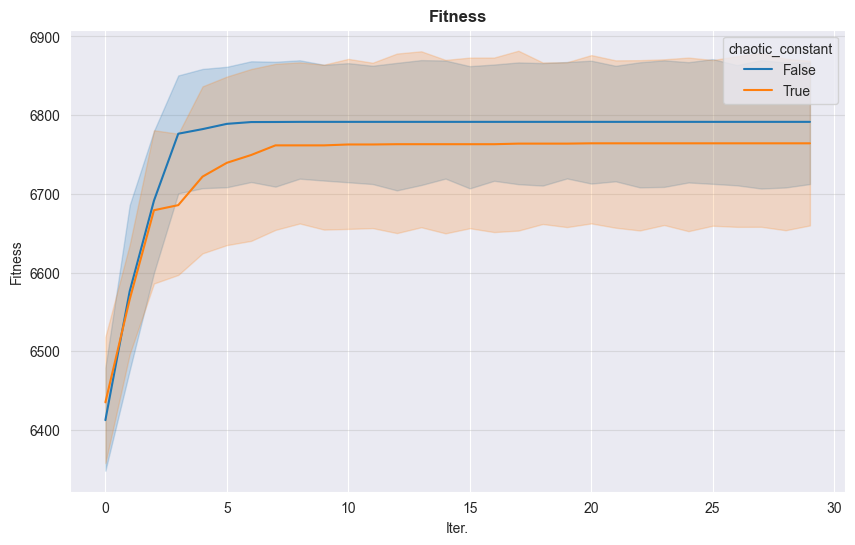

In [112]:
import seaborn as sns

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [80]:
# Get last value in column 'Real' of training_history
best_solution_real = training_history.iloc[-1]['Real']
best_solution_real

array([1303, 1372, 1493, 1587,  600,  682,  800,  913,  933, 1040, 1101,
       1145,  962, 1009, 1122, 1212, 1245,  535,  620,  738, 1283, 1392,
        976, 1021,  972, 1049, 1087, 1138,  479,  489,  566,  635,  264,
        312,  105,  224,  286,  393,   79,  142, 1233, 1301, 1407, 1484,
       1590, 1373, 1408, 1449, 1517,  633,  741,  350, 1138, 1231,  652,
        704,  757,  700,  736,  776,  333, 1329, 1433, 1478, 1577, 1274,
       1383, 1479,   85,  150,  271,  361,  461, 1058, 1148, 1261, 1346,
          1, 1374, 1019, 1099, 1234,  997, 1047, 1140, 1246, 1365, 1425,
       1481,  227,  337, 1361, 1411,   43,  140,  204,  326,  400,  703,
        847,  952,  340,  433,   34,  136,  564,  601, 1191, 1281, 1374,
        715,  814,  858,  893,  952,  683,  805,  845,  887,  775,  837,
        766,  499,  602,  698,  733,  830,   -1,  118,  196,   95,  154,
        189,  300, 1034, 1150,  236,  310,  383,  446])

In [81]:
sm.best_solution.real

array([ 1.301e+03,  1.371e+03,  1.490e+03,  1.584e+03,  6.030e+02,
        6.840e+02,  8.050e+02,  9.180e+02,  9.340e+02,  1.041e+03,
        1.101e+03,  1.144e+03,  9.630e+02,  1.009e+03,  1.123e+03,
        1.211e+03,  1.247e+03,  5.350e+02,  6.190e+02,  7.370e+02,
        1.277e+03,  1.390e+03,  9.750e+02,  1.020e+03,  9.760e+02,
        1.054e+03,  1.091e+03,  1.143e+03,  4.780e+02,  4.880e+02,
        5.670e+02,  6.370e+02,  2.660e+02,  3.140e+02,  1.040e+02,
        2.220e+02,  2.850e+02,  3.920e+02,  8.100e+01,  1.450e+02,
        1.237e+03,  1.302e+03,  1.411e+03,  1.485e+03,  1.591e+03,
        1.371e+03,  1.405e+03,  1.444e+03,  1.514e+03,  6.320e+02,
        7.410e+02,  3.450e+02,  1.143e+03,  1.235e+03,  6.550e+02,
        7.050e+02,  7.580e+02,  7.010e+02,  7.340e+02,  7.770e+02,
        3.310e+02,  1.329e+03,  1.431e+03,  1.478e+03,  1.576e+03,
        1.277e+03,  1.376e+03,  1.471e+03,  8.500e+01,  1.520e+02,
        2.710e+02,  3.610e+02,  4.610e+02,  1.054e+03,  1.145e

In [82]:
best_solution = Solution(real=np.array(best_solution_real), discrete=sm.get_heuristic_schedule(np.array(best_solution_real)))

best_solution.real, best_solution.discrete

(array([1303, 1372, 1493, 1587,  600,  682,  800,  913,  933, 1040, 1101,
        1145,  962, 1009, 1122, 1212, 1245,  535,  620,  738, 1283, 1392,
         976, 1021,  972, 1049, 1087, 1138,  479,  489,  566,  635,  264,
         312,  105,  224,  286,  393,   79,  142, 1233, 1301, 1407, 1484,
        1590, 1373, 1408, 1449, 1517,  633,  741,  350, 1138, 1231,  652,
         704,  757,  700,  736,  776,  333, 1329, 1433, 1478, 1577, 1274,
        1383, 1479,   85,  150,  271,  361,  461, 1058, 1148, 1261, 1346,
           1, 1374, 1019, 1099, 1234,  997, 1047, 1140, 1246, 1365, 1425,
        1481,  227,  337, 1361, 1411,   43,  140,  204,  326,  400,  703,
         847,  952,  340,  433,   34,  136,  564,  601, 1191, 1281, 1374,
         715,  814,  858,  893,  952,  683,  805,  845,  887,  775,  837,
         766,  499,  602,  698,  733,  830,   -1,  118,  196,   95,  154,
         189,  300, 1034, 1150,  236,  310,  383,  446]),
 array([False, False,  True,  True,  True,  True,  Tru

In [95]:
sm.is_feasible(best_solution, best_solution.discrete)

True

In [96]:
sm.get_fitness_gsa(best_solution_real)

(8677.129792586407, 0)

In [97]:
sm.get_revenue(best_solution)

8677.129792586407

In [98]:
sm.get_revenue(sm.best_solution)

9177.57968167765

In [99]:
sm.is_feasible(sm.best_solution, sm.best_solution.discrete)

True

In [100]:
sm.get_revenue(sm.best_solution)

9177.57968167765

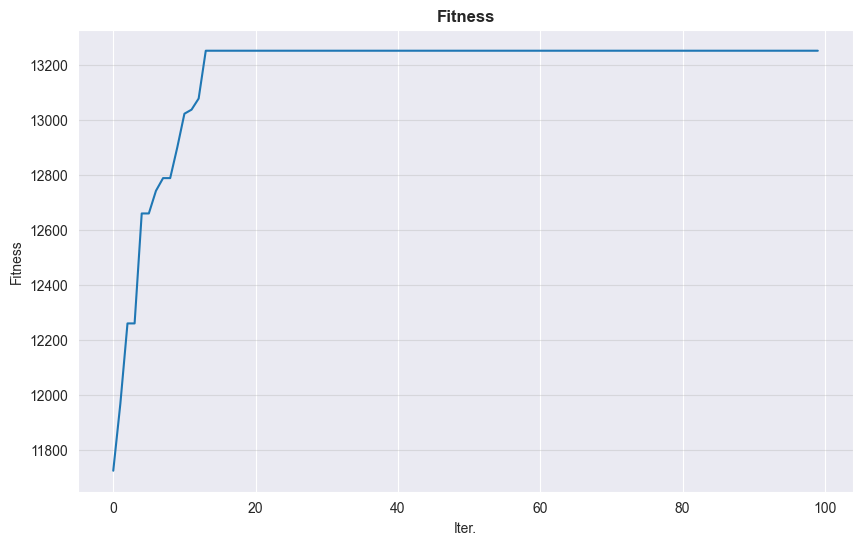

In [55]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [56]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [8]:
sum([revenue[service]['canon'] for service in revenue])

662.75

In [104]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,7863.690882,0,0.077843,[],"[1308, 1378, 1496, 1589, 609, 690, 807, 921, 9..."
1,1,8200.045549,0,0.334432,[],"[1302, 1371, 1491, 1586, 606, 687, 803, 916, 9..."
2,2,8428.372385,0,0.594928,[],"[1301, 1370, 1489, 1584, 603, 684, 801, 914, 9..."
3,3,8428.372385,0,0.861753,[],"[1301, 1370, 1489, 1584, 603, 684, 801, 914, 9..."
4,4,8447.990732,0,1.110731,[],"[1303, 1374, 1492, 1585, 604, 684, 803, 915, 9..."
...,...,...,...,...,...,...
95,95,8550.495681,0,21.481643,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
96,96,8550.495681,0,21.679128,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
97,97,8550.495681,0,21.877871,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
98,98,8550.495681,0,22.077040,[],"[1304, 1372, 1491, 1586, 602, 684, 802, 915, 9..."
